In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics

df = pd.read_excel('Online_Retail.xlsx')

In [32]:
#Extracting RFM data set 

df2 = df.copy()
#df = df.head(500)

customers = df['CustomerID'].unique()

def find_sum(df):
    monetary = 0
    for row  in df.iterrows():
        quantity = row[1][3]
        price = row[1][5]
        monetary += quantity*price
    return monetary 

def find_month(df):   #### instead of months, do weeks in between for improvement ###
    recent = -2
    for row in df.iterrows():
        #the time is stored as pandas.timestamp object, which has attributes month, year
        month=row[1][4].month

        #only december of 2010 recorded. Make december 2010 = -1 so it returns 13 
        if row[1][4].year == 2010:
            month = -1 

        if month > recent:
            recent = month
    return 12 - recent

RFM = pd.DataFrame(columns= ["Recency","Frequency","Monetary"])

for i in customers:
    #grab all transaction from current customer
    customer = df.loc[df['CustomerID'] == i]

    recency = find_month(customer)
    frequency = len(customer.index) #number of transactions
    monetary = find_sum(customer)

    data = {'Recency':recency, 'Frequency':frequency, 'Monetary':monetary}
    RFM = RFM.append(data, ignore_index=True)
df = df2

#USE RFM AS THE DATASET 

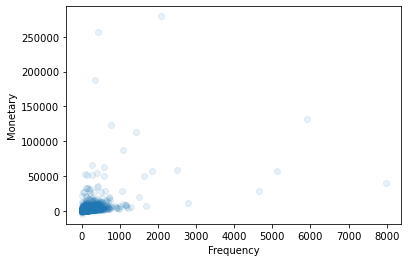

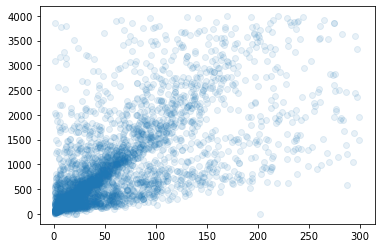

In [33]:
#Quick observation in the data
plt.scatter(RFM['Frequency'], RFM['Monetary'],alpha=0.1)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

#There are clear outliers, removing them for now
########## I just eyeballed the outliers for convinence. Use actual statistical methods to remove outliers ################
RFM2 = RFM.copy()

RFM2 = RFM2[RFM2['Monetary'] < 4000]
RFM2 = RFM2[RFM2['Monetary'] > 0]
RFM2 = RFM2[RFM2['Frequency'] < 300] 

plt.scatter(RFM2['Frequency'], RFM2['Monetary'],alpha = 0.1)
plt.show()

#RFM2 = RFM

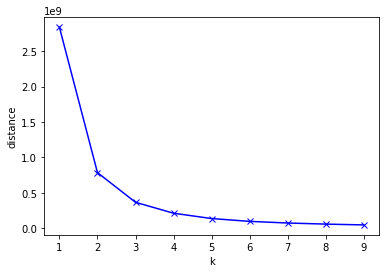

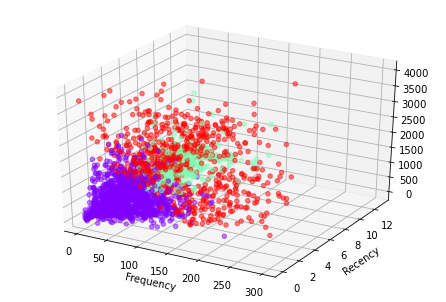

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#preprocess

#standardizing it
mms = MinMaxScaler()
mms.fit(RFM2)
x = mms.transform(RFM2)
normal_data = pd.DataFrame(x,columns= ["Recency","Frequency","Monetary"])


#Elbow Method to find optimal K 

distance = []
for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(RFM2)
    distance.append(km.inertia_)

plt.plot(range(1,10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('distance')
plt.show()
#gives us k = 3 when looking at the graph 

#K means clustering 
k_cluster = KMeans(n_clusters= 3)
predict = k_cluster.fit_predict(normal_data)

#PLOTTING
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(RFM2['Frequency'], RFM2['Recency'], RFM2['Monetary'],c=predict, cmap='rainbow',alpha = 0.5)
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

#FM2 = RFM


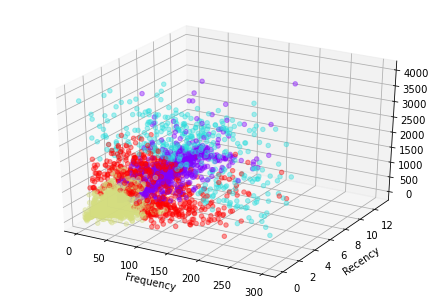

In [35]:
#try other methods 
from sklearn.cluster import AgglomerativeClustering

#Hierachical Clustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
prediction2 = cluster.fit_predict(normal_data)

#Plotting
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(RFM2['Frequency'], RFM2['Recency'], RFM2['Monetary'],c=prediction2, cmap='rainbow',alpha = 0.4)
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()

######## Should do cluster Validation to compare the algorithims ####################

In [58]:
#Finding RFM stats for each clusters 

kmeans_data = RFM2.copy()
kmeans_data['Cluster'] = predict


def find_cluster_stats(df):
    cluster_stats = pd.DataFrame(columns= ["Ratio","Recency","Frequency","Monetary","Cluster"])
    predictions = df['Cluster'].unique()

    for i in range(len(predictions)):
        #grab all instances of this cluster
        cluster = df.loc[df['Cluster'] == i]
        
        #find distribution        
        ratio = len(cluster.index)/len(df.index) 
        s = []
        for column in cluster:
            x= []
            #Monetary values ugly due to earlier calculations. Round to 2 decimals
            x.append(round(cluster[column].min(),2))
            x.append(round(cluster[column].max(),2))
            x.append(round(cluster[column].median(),2))
            s.append(x)

        #add to own data frame
        data = {'Ratio':ratio, 'Recency':s[0], 'Frequency':s[1], 'Monetary':s[2],'Cluster':i}
        cluster_stats = cluster_stats.append(data, ignore_index=True)
    return cluster_stats

x = find_cluster_stats(kmeans_data)
#Each column has a list of len 3. [Min,Max,Median]
print(x)

'''
There are clear different customers with K-means clustering, with K = 3.
First group, is the "worst customers", they have not visited recently (median = 9 months), they do not shop often (median = 17), and spend much less than anyone else (median = 294). 23% fall into this group
Second is the most common, with 55% of the people, they visit decently often (median = 2), shop more (median = 31), and spends more (median = 499)
Third, is the big spenders. Visiting often (median =1), very often(median = 131), and spending alot (median = 2101)
'''



      Ratio           Recency            Frequency  \
0  0.553093   [0.0, 5.0, 2.0]   [1.0, 202.0, 31.0]   
1  0.236598  [6.0, 13.0, 9.0]   [1.0, 170.0, 17.5]   
2  0.210309  [0.0, 10.0, 1.0]  [1.0, 299.0, 131.0]   

                     Monetary Cluster  
0       [0.0, 2207.4, 499.55]       0  
1      [0.0, 2661.24, 294.21]       1  
2  [532.96, 3991.94, 2101.74]       2  
